In [1]:
import pandas as pd

data=pd.read_csv("loadmetro.csv" )

#data

In [2]:
# Specify the columns you want to keep
columns_to_keep = ['datetime','Load', 'PS']

# Use indexing to select the desired columns
df = data[columns_to_keep]
# set the 'datetime_column' as the index
df.set_index('datetime', inplace=True)
df

,Load,PS
datetime,,
2019-03-21 00:00:00,352.862799,80.80
2019-03-21 01:00:00,330.444853,80.78
2019-03-21 02:00:00,287.419792,80.77
2019-03-21 03:00:00,258.110368,80.76
2019-03-21 04:00:00,247.745866,80.75
...,...,...
2021-09-22 19:00:00,632.235500,80.71
2021-09-22 20:00:00,612.703162,80.72
2021-09-22 21:00:00,589.574385,80.72


In [3]:
train_size = int(len(df) * 0.8)  # Calculate the size of the training set as 60% of the total data length
test_size = len(df) - train_size  # Calculate the size of the test set as the remaining 40% of the data

# Split the DataFrame 'df' into the training set and test set
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(len(train), len(test))  # Print the lengths of the training set and test set

test_size = int(len(test) * 0.5)  # Calculate the new size of the test set as 50% of the current test set length
val_size = len(test) - test_size  # Calculate the size of the validation set as the remaining 50% of the current test set

# Split the current test set into the validation set and a new test set
val, test = test.iloc[0:test_size], test.iloc[test_size:len(test)]
print(len(val), len(test))  # Print the lengths of the training set and test set


17606 4402
2201 2201


In [4]:
"""The code performs feature scaling using MinMaxScaler from the scikit-learn library. It first fits the scaler on the training data and then applies the transformation to the training, validation, and test sets."""

from sklearn.preprocessing import MinMaxScaler  # Import the MinMaxScaler class from the sklearn.preprocessing module

f_columns = ['PS']  # Define a list of column names to be transformed

f_transformer = MinMaxScaler()  # Create an instance of MinMaxScaler for feature transformation
t_transformer = MinMaxScaler()  # Create an instance of MinMaxScaler for target transformation

f_transformer = f_transformer.fit(train[f_columns].to_numpy())  # Fit the feature transformer to the training data
t_transformer = t_transformer.fit(train[['Load']])  # Fit the target transformer to the training data

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())  # Apply feature transformation to the training data
train['Load'] = t_transformer.transform(train[['Load']])  # Apply target transformation to the training data

val.loc[:, f_columns] = f_transformer.transform(val[f_columns].to_numpy())  # Apply feature transformation to the validation data
val['Load'] = t_transformer.transform(val[['Load']])  # Apply target transformation to the validation data

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())  # Apply feature transformation to the test data
test['Load'] = t_transformer.transform(test[['Load']])  # Apply target transformation to the test data


<ipython-input-4-f541a644836d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())  # Apply feature transformation to the training data
<ipython-input-4-f541a644836d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Load'] = t_transformer.transform(train[['Load']])  # Apply target transformation to the training data


In [5]:
"""The code defines a function called create_dataset that takes in input features X, target variable y, and a parameter time_steps. It creates a dataset suitable for time series forecasting by splitting the input features and target variable into sequences of length time_steps."""
import numpy as np
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []  # Initialize empty lists to store the input sequences (Xs) and corresponding target values (ys)
    for i in range(len(X) - time_steps):  # Iterate over the range of indices up to the length of X minus time_steps
        v = X.iloc[i:(i + time_steps)].values  # Extract a sequence of length time_steps from X
        Xs.append(v)  # Append the sequence to Xs
        ys.append(y.iloc[i + time_steps])  # Append the corresponding target value to ys
    return np.array(Xs), np.array(ys)  # Convert Xs and ys to NumPy arrays and return them





"""The code sets the value of time_steps to 24, which represents the number of time steps or previous observations to consider for each sample in the dataset. It then uses the create_dataset function to create training, validation, and test datasets by reshaping the input features and target variables into the appropriate format."""

time_steps = 24  # Set the number of time steps to 24

X_train, y_train = create_dataset(train, train.Load, time_steps)  # Create the training dataset using the 'create_dataset' function

X_validate, y_validate = create_dataset(val, val.Load, time_steps)  # Create the validation dataset using the 'create_dataset' function

X_test, y_test = create_dataset(test, test.Load, time_steps)  # Create the test dataset using the 'create_dataset' function

In [6]:
print(X_train.shape,y_train.shape, X_validate.shape, y_validate.shape,X_test.shape,  y_test.shape)

(17582, 24, 2) (17582,) (2177, 24, 2) (2177,) (2177, 24, 2) (2177,)


In [7]:
import math
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
from keras.callbacks import EarlyStopping


In [8]:


def build_model(num_layers, units, dropout_rates):
    model = keras.Sequential()

    for i in range(num_layers):
        return_sequences = (i != num_layers - 1)  # Set return_sequences=True for all but the last layer

        model.add(layers.LSTM(units=units[i], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=return_sequences))
        model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mean_squared_error',
        metrics=['mae','mape'])
    return model

# Optimized hyperparameters
num_layers = 3
units = [260 , 320 , 20 ]
dropout_rates = [0.2, 0.0, 0.0]


model = build_model(num_layers, units, dropout_rates)

# Create an instance of EarlyStopping callback
custom_early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor for early stopping (validation loss)
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    start_from_epoch=20
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_validate, y_validate)
    #callbacks=[custom_early_stopping]
   )

Epoch 1/100
550/550 [==============================] - 142s 246ms/step - loss: 0.0030 - mae: 0.0387 - mape: 46782.0820 - val_loss: 0.0014 - val_mae: 0.0286 - val_mape: 5.8174
Epoch 2/100
550/550 [==============================] - 130s 236ms/step - loss: 9.6545e-04 - mae: 0.0233 - mape: 54539.1445 - val_loss: 0.0012 - val_mae: 0.0248 - val_mape: 5.1383
Epoch 3/100
550/550 [==============================] - 133s 242ms/step - loss: 6.8206e-04 - mae: 0.0189 - mape: 51344.4922 - val_loss: 8.2279e-04 - val_mae: 0.0210 - val_mape: 4.1544
Epoch 4/100
550/550 [==============================] - 131s 238ms/step - loss: 4.4653e-04 - mae: 0.0153 - mape: 53151.8398 - val_loss: 4.9816e-04 - val_mae: 0.0166 - val_mape: 3.3494
Epoch 5/100
550/550 [==============================] - 132s 240ms/step - loss: 3.5140e-04 - mae: 0.0135 - mape: 52205.3008 - val_loss: 4.3903e-04 - val_mae: 0.0159 - val_mape: 3.2533
Epoch 6/100
550/550 [==============================] - 132s 240ms/step - loss: 3.1254e-04 - mae: 

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 260)           273520    
                                                                 
 dropout (Dropout)           (None, 24, 260)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 320)           743680    
                                                                 
 dropout_1 (Dropout)         (None, 24, 320)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                27280     
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [10]:
import pickle
# Save the trained model as a pickle string.
saved_model = pickle.dumps(history)

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM_PS.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("LSTM_PS.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


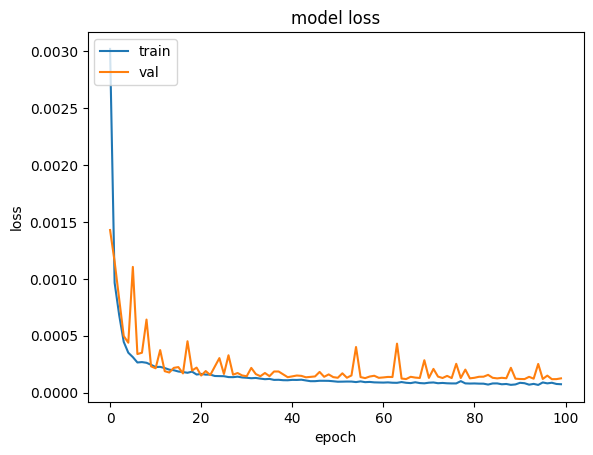

In [12]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')



In [13]:
from math import sqrt
from sklearn.metrics import mean_squared_error


y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_validate)


#inverse
y_train_inv = t_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = t_transformer.inverse_transform(y_test.reshape((len(y_test), 1)))
y_pred_inv = t_transformer.inverse_transform(y_pred)

y_validate_inv = t_transformer.inverse_transform(y_validate.reshape(-1, 1))

y_pred_train_inv = t_transformer.inverse_transform(y_pred_train)
y_pred_val_inv = t_transformer.inverse_transform(y_pred_val)

69/69 [==============================] - 5s 76ms/step


In [14]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.9f' % rmse)


# calculate MAE
from sklearn.metrics import mean_absolute_error
mae= mean_absolute_error(y_test_inv, y_pred_inv)
print('Test MAE: %.9f' % mae)


# calculate MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape= mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('Test MAPE: %.9f' % mape)

# calculate NRMSE
actual_test=y_test_inv
Nrmse_test=rmse /(actual_test.max() - actual_test.min())
print('Test NRMSE: %.9f' % Nrmse_test)


Test RMSE: 20.361404391
Test MAE: 11.127440763
Test MAPE: 0.018953244
Test NRMSE: 0.027576872


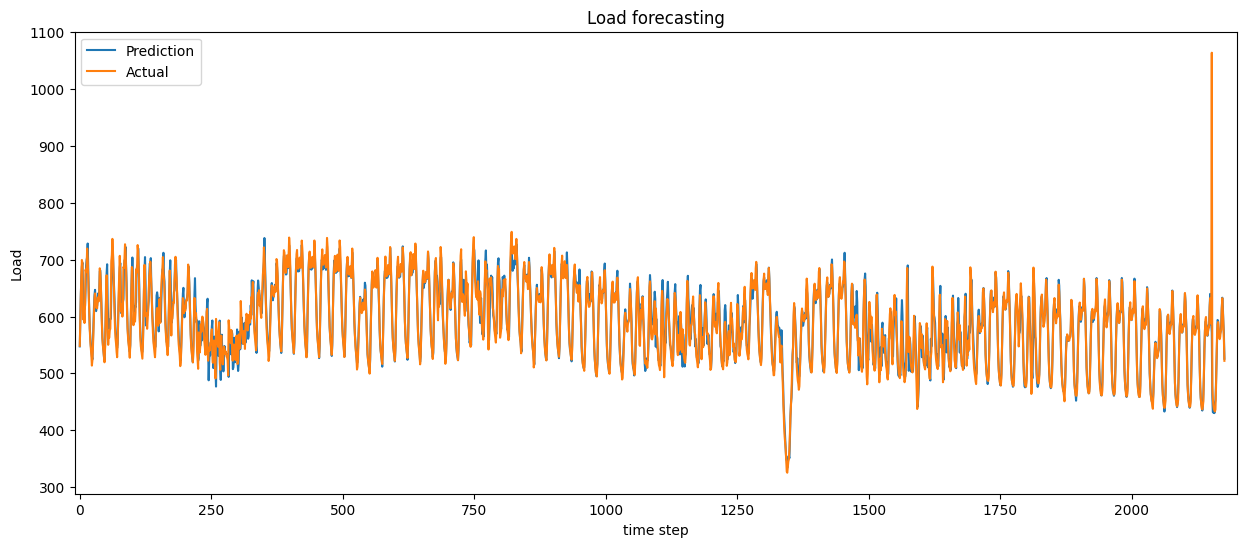

In [15]:
plt.figure(figsize=(15,6))

plt.plot(y_pred_inv, label="Prediction" )
plt.plot(y_test_inv, label="Actual")
plt.legend()
plt.ylabel('Load')
plt.xlabel('time step' )
#plt.title ("Russell 2000 Adj close Price prediction- with MAE {:10.4f}".format(mae))
plt.title ('Load forecasting')

plt.xlim(
  xmin=-10, xmax=2200
)
#plt.show()


plt.savefig("PS.svg")
plt.savefig("PS.png", format="png", dpi=300)
plt.savefig('PS.eps', format='eps')




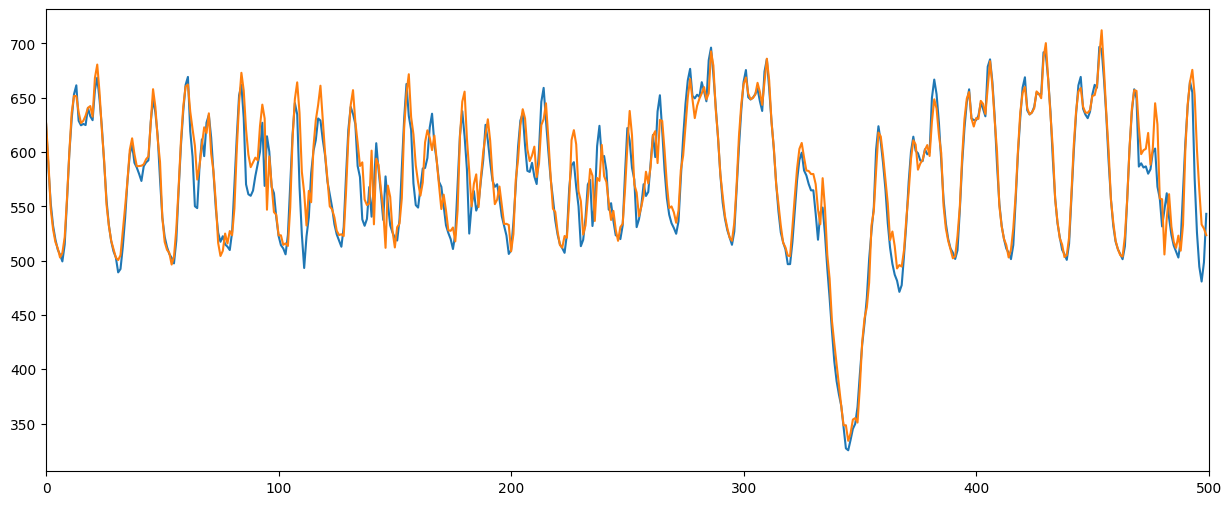

In [16]:
#zoom in spikes


plt.figure(figsize=(15,6))

plt.plot(y_test_inv[1000:1500])
plt.plot(y_pred_inv[1000:1500])
plt.xlim(
  xmin=0, xmax=500
)
#plt.show()




plt.savefig("PS_zoomin.svg")
plt.savefig("PS_zoomin.png", format="png", dpi=300)
plt.savefig('PS_zoomin.eps', format='eps')
